<a href="https://colab.research.google.com/github/Himanshu-1703/reddit-sentiment-analysis/blob/main/Reddit_Data_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Packages

In [31]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import missingno
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
from collections import Counter
from nltk.tokenize import word_tokenize

In [32]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

# Load Data

In [33]:
# load the data

DATA_PATH = r"https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv"

df = pd.read_csv(DATA_PATH)

df

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [34]:
# rename columns

df.rename({"clean_comment":"comment",
           "category":"sentiment"},axis=1,inplace=True)

In [35]:
# missing data

df.isna().sum()

,0
comment,100
sentiment,0


**There are 100 missing values in the comment**

<Axes: >

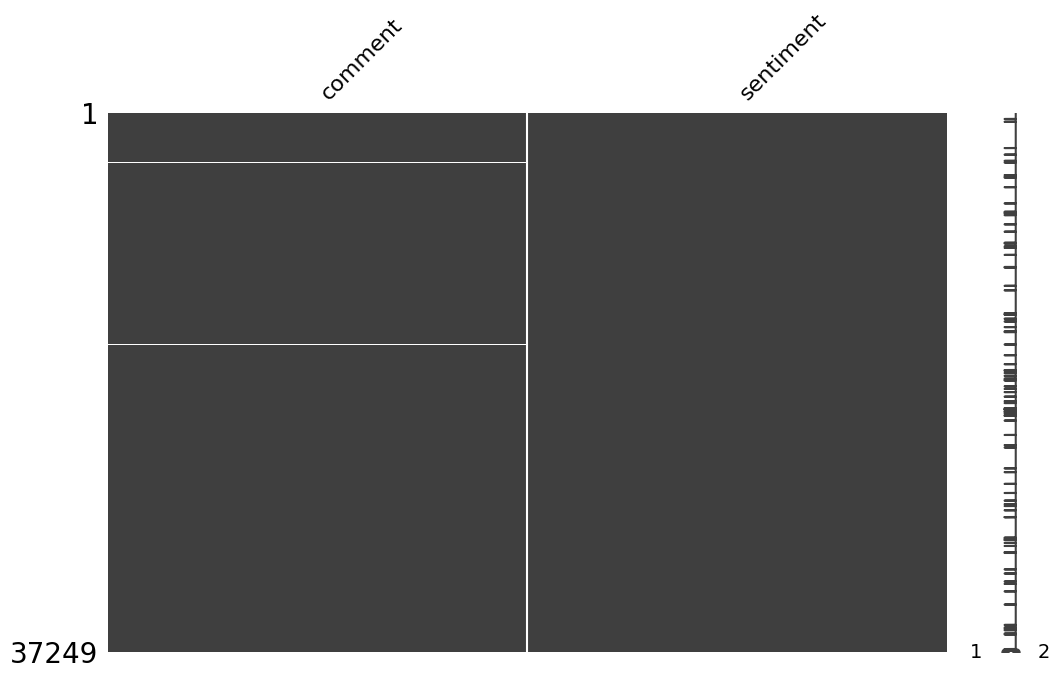

In [36]:
# missing values matrix

missingno.matrix(df,figsize=(12,7))

In [37]:
# rows that have missing values

(
    df.loc[
        df['comment'].isna()
    ]
)

,comment,sentiment
413,NaN,0
605,NaN,0
2422,NaN,0
2877,NaN,0
3307,NaN,0
...,...,...
35975,NaN,0
36036,NaN,0
37043,NaN,0
37111,NaN,0


In [38]:
# sentiment of rows that have missing values

(
    df.loc[
        df['comment'].isna(),"sentiment"
    ]
    .value_counts()
)

,count
sentiment,
0,100


**All rows that have missing values have been labelled the sentiment of 0 (neutral)**

In [39]:
# check for duplicate comments in the data

print(df['comment'].dropna().duplicated().sum())

350


**`350` comments in the data are duplicated**

In [40]:
# shape of the data

data_rows, data_cols = df.shape
print(f'The data has {data_rows} rows and {data_cols} columns')

The data has 37249 rows and 2 columns


In [41]:
# comments having words like modi,bjp and congress

(
    df
    .dropna()
    .loc[(lambda df_: df_['comment'].str.contains(r"bjp|congress|modi")),"comment"]
)

,comment
51,tea partier expresses support for namo after ...
68,can congress eliminate namo and blame advani
69,don know but surely there his statue every bj...
70,after seeing this uvjx3kwoehw video seems anyt...
72,congress needs bogeyman modi without the bad g...
...,...
37210,modi april fool
37228,also modiji will give award ravish kumar tonight
37236,fan modi but some the best people ever met li...
37245,kya bhai pure saal chutiya banaya modi aur jab...


In [42]:
# distribution of such comments

print(
      df['comment']
      .dropna()
      .str.contains(r"bjp|congress|modi")
      .mean() * 100
    )

18.991089935126112


# Data Cleaning

In [43]:
len(df.loc[14037,'comment'].split())

2

In [44]:
# check for rows that have empty rows, only whitespace and new line characters

whitespace_chars = [" ","\n"]

df.loc[df['comment'].isin(whitespace_chars),"comment"]

,comment
181,
375,
392,
651,
1222,
...,...
35711,
35778,
35987,
36707,


In [45]:
def remove_whitespaces(ser):
    return ser.str.lstrip().str.rstrip()

def remove_whitespace_chars(ser):
    chars_list = [" ","\n"]
    return ser[ser.isin(chars_list)]

def count_words(text):
    return len(text.split(" "))

def removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    return text

def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def clean_text(text):
    text = removing_numbers(text)
    text = removing_punctuations(text)
    text = removing_urls(text)
    return text

def sentence_length(ser):
    bins = [0,10, 25, 50, ser.max()]
    labels = ['Short', 'Medium', 'Long', 'Very Long']
    return pd.cut(ser,bins=bins,labels=labels)

def is_response(ser):
    return np.where(ser <= 3, 1, 0)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

def lemmatize(text):
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text.split(" ")]
    return " ".join(text)


In [46]:
def remove_emoji(text):
    # Regex pattern to match all emoji characters
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
        u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_non_ascii(text):
    # Remove all non-ASCII characters
    return re.sub(r'[^\x00-\x7F]+', '', text)

def remove_chinese(text):
    # Regex to remove Chinese characters (CJK Unified Ideographs)
    return re.sub(r'[\u4e00-\u9fff]+', '', text)

def clean_unicode_text(text):
    # Apply all cleaning functions
    text = remove_emoji(text)
    text = remove_chinese(text)
    text = remove_non_ascii(text)
    return text

In [47]:
df['comment'].dropna().apply(count_words)

,comment
0,41
1,197
2,87
3,30
4,113
...,...
37244,1
37245,19
37246,8
37247,3


In [48]:
def count_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    stop_words_only = [word for word in word_tokens if word.lower() in stop_words]
    return len(stop_words_only)

In [49]:
df['comment'].dropna().sample(25).apply(count_stop_words)

,comment
4185,5
14219,0
2080,3
2481,20
9821,3
33083,0
19905,3
10365,42
16595,4
3525,4


In [50]:
def count_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Define POS categories
    nouns = ['NN', 'NNS', 'NNP', 'NNPS']
    verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    adjectives = ['JJ', 'JJR', 'JJS']

    # Count the POS tags
    pos_counts = Counter(tag for word, tag in pos_tags)

    num_nouns = sum(pos_counts[pos] for pos in nouns)
    num_verbs = sum(pos_counts[pos] for pos in verbs)
    num_adjectives = sum(pos_counts[pos] for pos in adjectives)
    return pd.Series({'nouns': num_nouns, 'verbs': num_verbs, 'adjectives': num_adjectives})

In [51]:
def clean_data(data):

    return (
        data
        .dropna()
        .drop_duplicates(subset=['comment'])
        .loc[lambda df_: ~df_['comment'].isin([" ","\n"])]
        .assign(
            stop_words_count = lambda df_: df_.loc[:,'comment'].apply(count_stop_words)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].str.lstrip().str.rstrip().str.lower(),
            word_count = lambda df_: df_.loc[:,"comment"].apply(count_words),
            named_sentiment = lambda df_: df_.loc[:,"sentiment"].replace({0:"neutral",
                                                                         -1:"negative",
                                                                          1:"positive"}),
            sentence_length = lambda df_: df_.loc[:,"word_count"].pipe(sentence_length),
            response = lambda df_: df_.loc[:,"word_count"].pipe(is_response)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(removing_punctuations)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_unicode_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(remove_stopwords)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(lemmatize)
        )
        .loc[lambda df_: ~(df_['comment'].str.contains(r"bjp|congress|modi")),:]
    )

In [52]:
final_df = clean_data(df)

In [53]:
final_df.sample(30)

,comment,sentiment,stop_words_count,word_count,named_sentiment,sentence_length,response
31256,people really start worrying elected leader qu...,1,5,15,positive,Medium,0
13943,mon pes k voted pretty sure lefty poll preside...,1,12,30,positive,Long,0
1658,east india exit poll prediction seat nda upa o...,0,1,10,neutral,Short,0
30767,worry brother whomever died paradise right sad...,-1,16,35,negative,Long,0
36972,man manner par chutiya bhosadi kaun tha lambe ...,0,0,12,neutral,Medium,0
475,langur rejoicing dievielopeamebt dievielopeame...,0,2,10,neutral,Short,0
27728,get access document,0,3,6,neutral,Short,0
21990,site showing bsp seat lead happen others jds,0,9,17,neutral,Medium,0
25596,happy way dumbfuck exploited constitution name...,1,8,19,positive,Medium,0
24490,nclt ibc resolved top case specifically introd...,-1,14,38,negative,Long,0


In [54]:
# form the pos tag count data

pos_tag_data = final_df['comment'].apply(count_pos_tags)

In [55]:
pos_tag_data

,nouns,verbs,adjectives
0,16,4,2
1,58,30,24
2,18,7,10
3,7,4,2
4,20,19,12
...,...,...,...
37242,8,0,0
37243,7,5,2
37244,1,0,0
37246,4,0,1


In [56]:
final_df = final_df.join(pos_tag_data)

In [57]:
# check cleaned df for missing values

final_df.isna().sum()

,0
comment,0
sentiment,0
stop_words_count,0
word_count,0
named_sentiment,0
sentence_length,0
response,0
nouns,0
verbs,0
adjectives,0


In [58]:
# shape of cleaned data

final_df.shape

(29751, 10)

In [59]:
# save the cleaned data as csv

final_df.to_csv("cleaned_data.csv",index=False)

# EDA

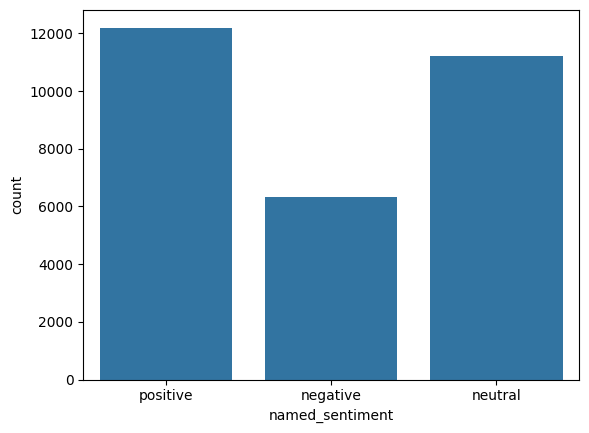

In [60]:
# distribution of classes

sns.countplot(data=final_df,x="named_sentiment");

**Clearly the data shows class imbalance**

In [61]:
# frequency distribution of sentiments

final_df['named_sentiment'].value_counts(normalize=True).mul(100).round(2)

,proportion
named_sentiment,
positive,41.01
neutral,37.68
negative,21.31


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


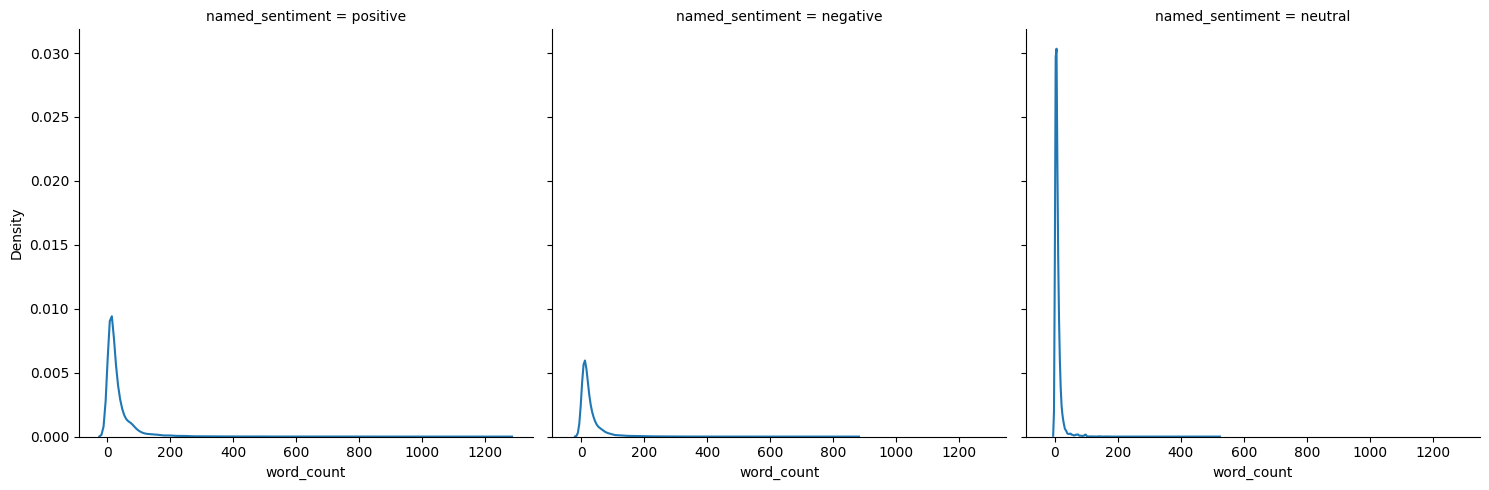

In [62]:
# distribution of word_count per sentiment

sns.displot(final_df,x='word_count',col='named_sentiment',kind='kde');

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='word_count', ylabel='Density'>

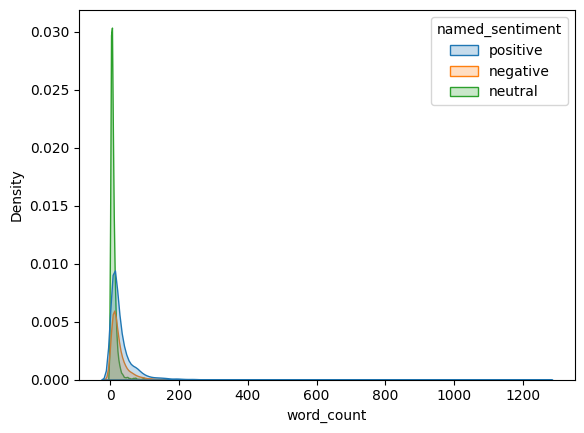

In [63]:
# distribution of word_count per sentiment

sns.kdeplot(final_df,x='word_count',hue='named_sentiment',fill=True)

In [64]:
# statistical summary of word_count

sentiment_grp = final_df.groupby("named_sentiment")

sentiment_grp['word_count'].agg(["min","max","median","mean"])

,min,max,median,mean
named_sentiment,,,,
negative,1,862,17.0,28.119577
neutral,1,518,6.0,9.372435
positive,1,1258,18.0,34.547369


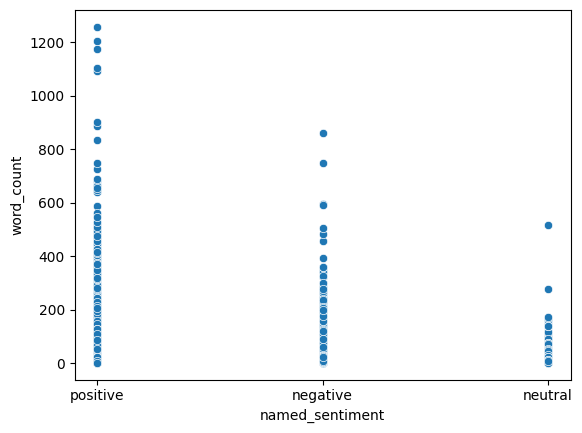

In [65]:
#sentiment vs word_count

sns.scatterplot(final_df,x='named_sentiment',y='word_count');

In [66]:
# sentiment vs word count --> boxplots

px.box(data_frame=final_df,x='named_sentiment',y='word_count')

In [67]:
# distribution of sentence length based on sentiment

pd.crosstab(index=final_df['named_sentiment'],columns=final_df['sentence_length'],normalize=True).mul(100)

sentence_length,Short,Medium,Long,Very Long
named_sentiment,,,,
negative,6.440120,7.835031,4.144399,2.887298
neutral,27.720077,8.117374,1.230211,0.611744
positive,12.480253,13.249975,7.912339,7.371181


In [68]:
import warnings

warnings.filterwarnings("ignore")
fig = px.sunburst(final_df,path=['named_sentiment','sentence_length'],width=700,height=700)
fig.show()

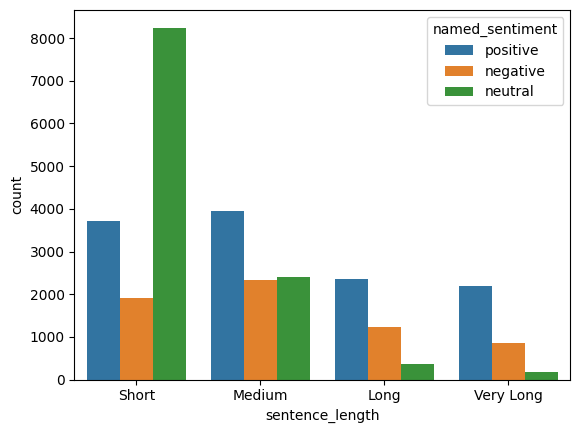

In [69]:
# sentence length distribution among sentences

sns.countplot(final_df,x='sentence_length',hue='named_sentiment');

<Axes: xlabel='stop_words_count', ylabel='Density'>

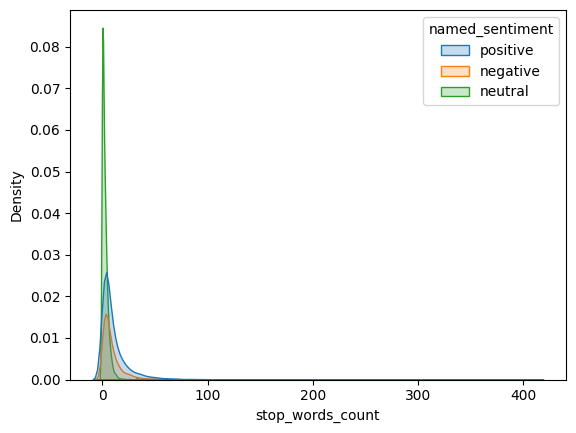

In [70]:
# kdeplot of stopwords count

sns.kdeplot(final_df,x='stop_words_count',hue='named_sentiment',fill=True)

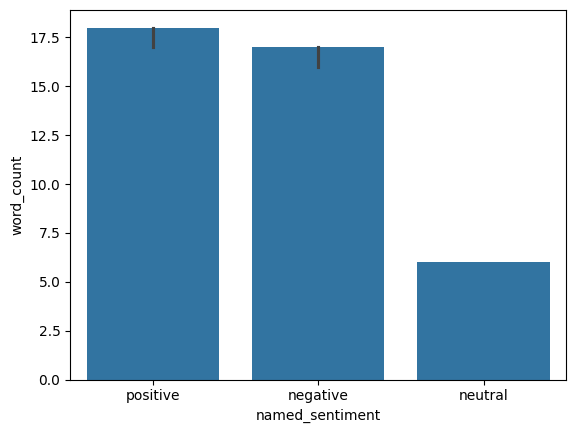

In [71]:
# median word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='median');

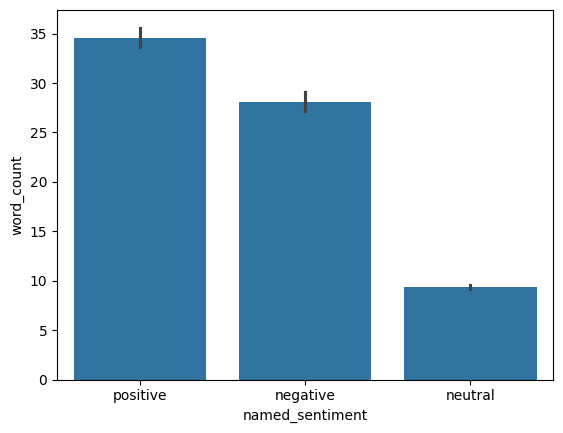

In [72]:
# avg word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='mean');

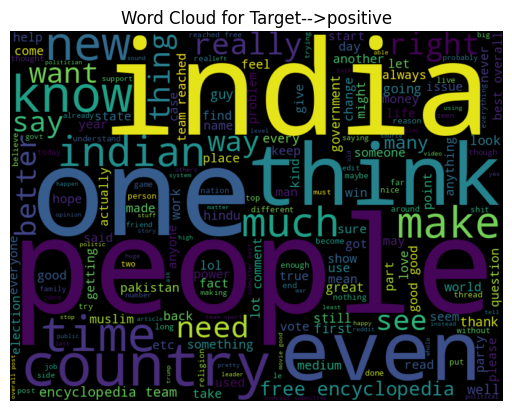

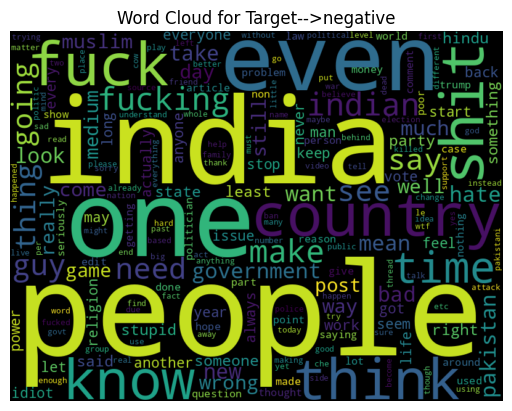

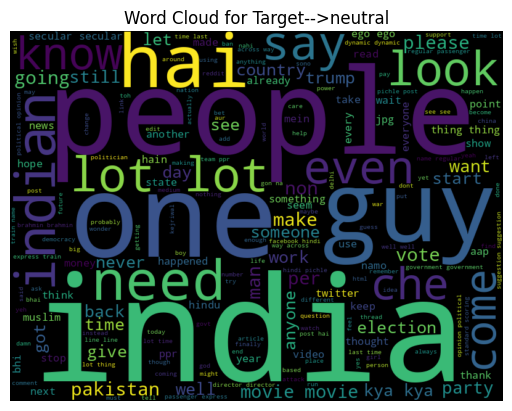

In [73]:
# plot wordclouds for each sentiment

def plot_wordcloud(target_class):
    text = ' '.join(final_df.loc[(final_df['named_sentiment'] == target_class),"comment"])
    wordcloud = WordCloud(width=800, height=600).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Target-->{target_class}')
    plt.show()

for sentiment in final_df['named_sentiment'].unique().tolist():
    plot_wordcloud(sentiment)

In [74]:
# top 15 words and their count in each sentiment

def tokenize_sentences(text):
    tokens = nltk.word_tokenize(text)
    return tokens

tokens = final_df.loc[:,"comment"].apply(tokenize_sentences)

positive_tokens = tokens.loc[final_df['named_sentiment'] == "positive"].sum()
neutral_tokens = tokens.loc[final_df['named_sentiment'] == "neutral"].sum()
negative_tokens = tokens.loc[final_df['named_sentiment'] == "negative"].sum()

In [75]:
# find the top 15 words

def get_top_words(tokens, n=10):
    word_counts = Counter(tokens)
    return word_counts.most_common(n)

top_15_positive = get_top_words(positive_tokens,15)
top_15_neutral = get_top_words(neutral_tokens,15)
top_15_negative = get_top_words(negative_tokens,15)

print("Top 10 words for Positive sentiment:", top_15_positive)
print("Top 10 words for Neutral sentiment:", top_15_neutral)
print("Top 10 words for Negative sentiment:", top_15_negative)

Top 10 words for Positive sentiment: [('good', 2358), ('people', 2222), ('like', 2080), ('india', 1894), ('one', 1665), ('would', 1399), ('get', 1336), ('time', 1173), ('even', 1123), ('think', 1073), ('right', 1056), ('thing', 1003), ('make', 985), ('indian', 985), ('know', 943)]
Top 10 words for Neutral sentiment: [('like', 540), ('india', 497), ('hai', 458), ('lot', 434), ('one', 391), ('time', 351), ('people', 313), ('get', 284), ('think', 261), ('thing', 245), ('che', 222), ('guy', 219), ('indian', 216), ('post', 208), ('kya', 205)]
Top 10 words for Negative sentiment: [('people', 1010), ('like', 894), ('india', 838), ('one', 719), ('get', 567), ('indian', 510), ('shit', 501), ('fuck', 493), ('thing', 488), ('even', 482), ('time', 482), ('would', 449), ('country', 421), ('know', 406), ('think', 399)]


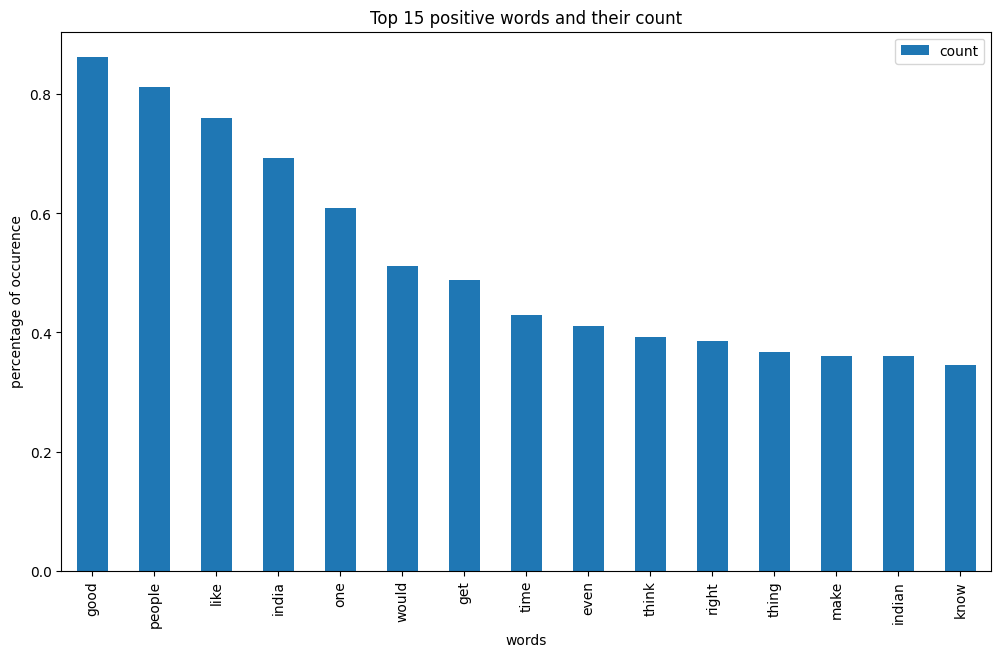

In [76]:
# bar plot for top 15 positive sentiment words
(
    pd.DataFrame(top_15_positive,columns=['word','count'])
    .set_index('word')
    .div(len(positive_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 positive words and their count")
plt.show()

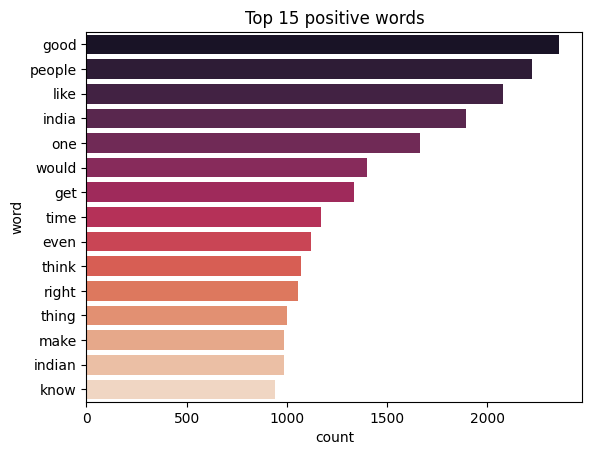

In [77]:
# plot the top 15 positive words

sns.barplot(data=pd.DataFrame(top_15_positive,columns=['word','count']),
            x='count',y='word',palette='rocket')
plt.title("Top 15 positive words")
plt.show()

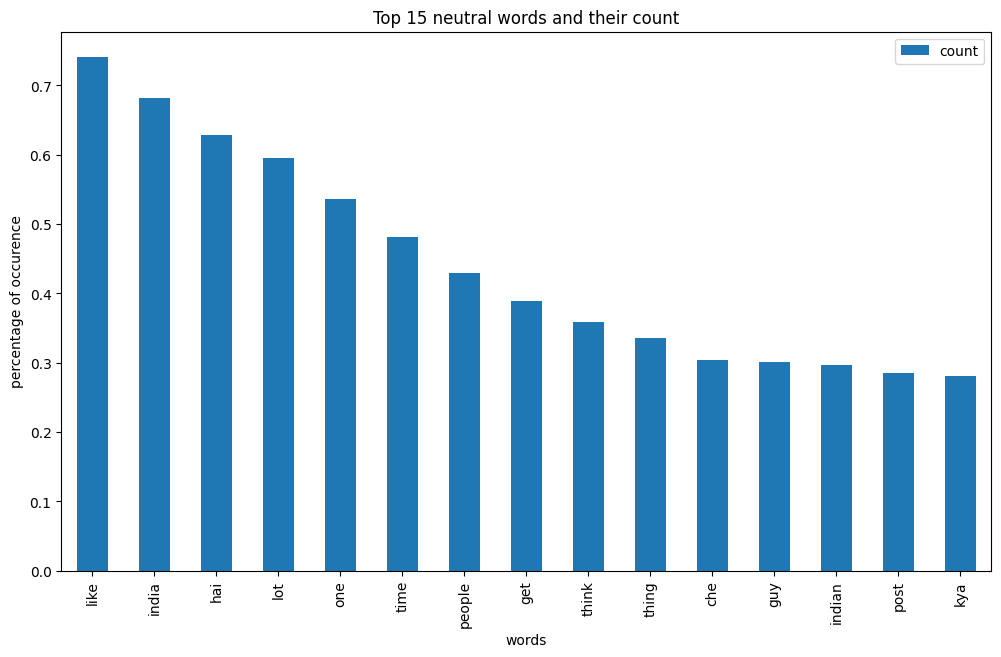

In [78]:
# bar plot for top 15 neutral sentiment words
(
    pd.DataFrame(top_15_neutral,columns=['word','count'])
    .set_index('word')
    .div(len(neutral_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 neutral words and their count")
plt.show()

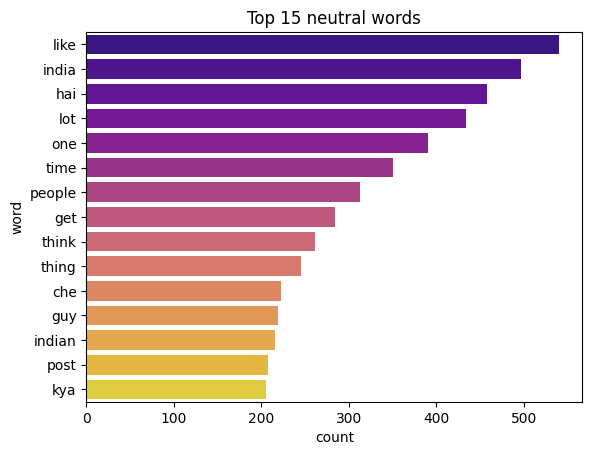

In [79]:
# plot the top 15 neutral words

sns.barplot(data=pd.DataFrame(top_15_neutral,columns=['word','count']),
            x='count',y='word',palette='plasma')
plt.title("Top 15 neutral words")
plt.show()

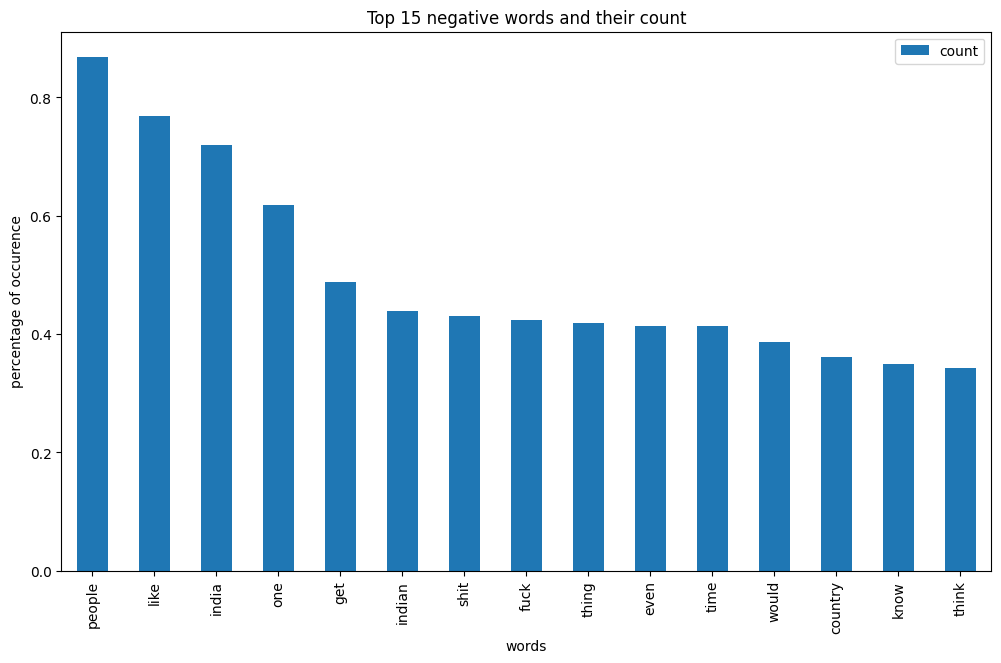

In [80]:
# bar plot for top 15 negative sentiment words
(
    pd.DataFrame(top_15_negative,columns=['word','count'])
    .set_index('word')
    .div(len(negative_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 negative words and their count")
plt.show()

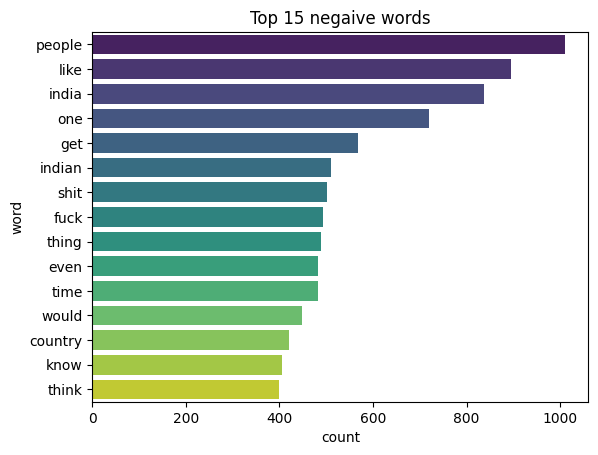

In [81]:
# plot the top 15 negative words

sns.barplot(data=pd.DataFrame(top_15_negative,columns=['word','count']),
            x='count',y='word',palette='viridis')
plt.title("Top 15 negaive words")
plt.show()

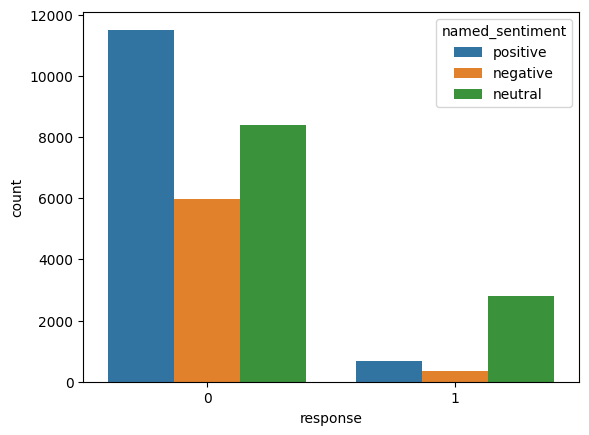

In [82]:
# distribution of responses among sentiments
sns.countplot(final_df,x='response',hue='named_sentiment');

**Response** --> This column denotes those comments which are a length of 3 or less words, which cannot be considered a comment but are feedbacks or responses

In [83]:
# response comments

(
    final_df
    .loc[(final_df['response'] == 1),"comment"]
)

,comment
18,zarus
46,nam indeed
47,jbdbxpxga
71,law headline
92,dry state
...,...
37230,nice try
37235,
37239,pmd
37244,jesus


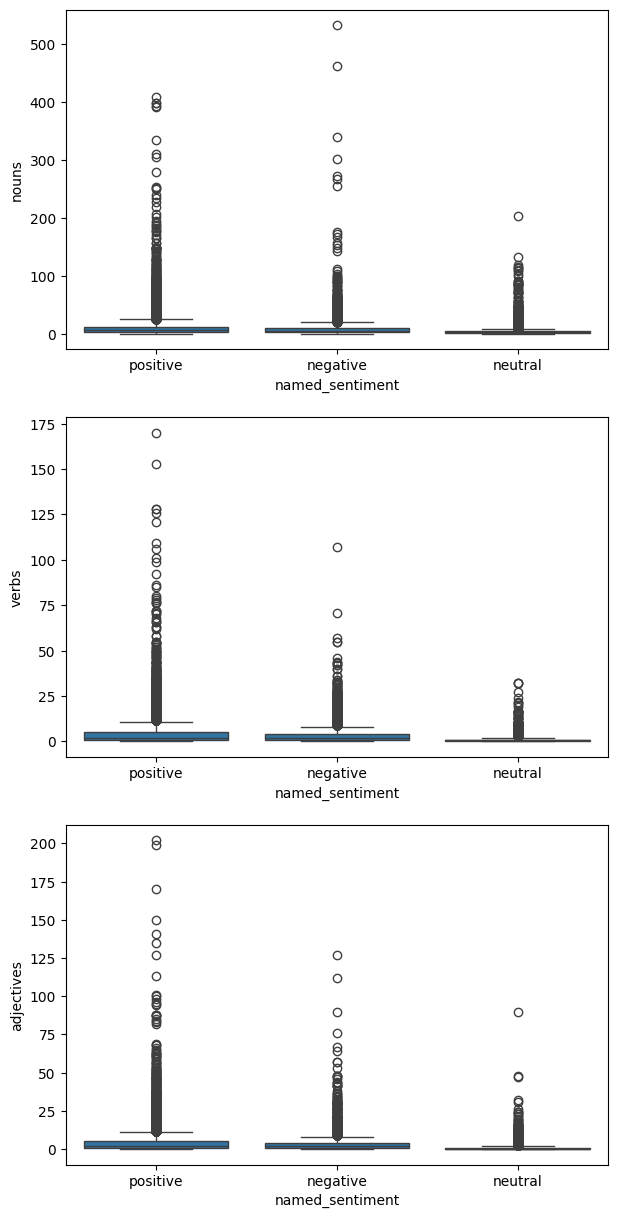

In [84]:
# boxplots for pos tags for each sentiment

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,15))

for ind,y in enumerate(final_df.columns[-3:].to_list()):
    sns.boxplot(data=final_df,x='named_sentiment',y=y,ax=ax[ind])

In [85]:
from math import floor

In [86]:
# statistical summary

sentiment_grp[['nouns','adjectives','verbs']].agg(["median","mean"]).map(floor)

nouns      adjectives       verbs     
                median mean     median mean median mean
named_sentiment                                        
negative             5    9          2    3      2    3
neutral              3    4          0    0      1    0
positive             6   10          2    4      2    4

# Model Pipeline

In [87]:
final_df.head()

,comment,sentiment,stop_words_count,word_count,named_sentiment,sentence_length,response,nouns,verbs,adjectives
0,family mormon never tried explain still stare ...,1,13,39,positive,Long,0,16,4,2
1,buddhism much lot compatible christianity espe...,1,59,196,positive,Very Long,0,58,30,24
2,seriously say thing first get complex explain ...,-1,40,86,negative,Very Long,0,18,7,10
3,learned want teach different focus goal wrappi...,0,15,29,neutral,Long,0,7,4,2
4,benefit may want read living buddha living chr...,1,45,112,positive,Very Long,0,20,19,12


In [88]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 5.1 MB/s eta 0:00:00


In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from feature_engine.encoding import CountFrequencyEncoder

## Feature Engineering

### Comments

In [90]:
count_vec = CountVectorizer(decode_error='ignore',
                            stop_words='english',
                            min_df=3)
count_vec.fit_transform(final_df['comment'].sample(30)).toarray()

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [3, 1, 2, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0]])

### Scaling

In [91]:
# scaling columns

cols_to_scale = ['word_count','stop_words_count','nouns','adjectives','verbs']

scaler = RobustScaler()

scaler.set_output(transform='pandas')

scaler.fit_transform(final_df[cols_to_scale])

,word_count,stop_words_count,nouns,adjectives,verbs
0,1.473684,1.285714,2.000000,0.333333,1.000000
1,9.736842,7.857143,9.000000,7.666667,9.666667
2,3.947368,5.142857,2.333333,3.000000,2.000000
3,0.947368,1.571429,0.500000,0.333333,1.000000
4,5.315789,5.857143,2.666667,3.666667,6.000000
...,...,...,...,...,...
37242,0.000000,-0.142857,0.666667,-0.333333,-0.333333
37243,0.578947,0.285714,0.500000,0.333333,1.333333
37244,-0.526316,-0.571429,-0.500000,-0.333333,-0.333333
37246,-0.263158,-0.571429,0.000000,0.000000,-0.333333


### Encoding

In [92]:
# categories in sentence length

final_df['sentence_length'].unique()

['Long', 'Very Long', 'Medium', 'Short']
Categories (4, object): ['Short' < 'Medium' < 'Long' < 'Very Long']

In [93]:
ord_encoder = OrdinalEncoder(categories=[['Short','Medium','Long','Very Long']])
ord_encoder.set_output(transform='pandas')
ord_encoder.fit_transform(final_df[['sentence_length']])

ord_encoder.categories_

[array(['Short', 'Medium', 'Long', 'Very Long'], dtype=object)]

In [94]:
# count encoding

count_enc = CountFrequencyEncoder(encoding_method='frequency')
count_enc.set_output(transform='pandas')
count_enc.fit_transform(final_df[['sentence_length']])

,sentence_length
0,0.132869
1,0.108702
2,0.108702
3,0.132869
4,0.108702
...,...
37242,0.292024
37243,0.292024
37244,0.466404
37246,0.466404


In [95]:
sentence_union = FeatureUnion([
    ('count_enc',count_enc),
    ('ord_encoder',ord_encoder)
])

sentence_union.set_output(transform='pandas')

sentence_union.fit_transform(final_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.132869,2.0
1,0.108702,3.0
2,0.108702,3.0
3,0.132869,2.0
4,0.108702,3.0
...,...,...
37242,0.292024,1.0
37243,0.292024,1.0
37244,0.466404,0.0
37246,0.466404,0.0


In [96]:
# pipeline of sentence length column

sentence_pipe = Pipeline([
    ('sentence_union',sentence_union),
    ('scale',MinMaxScaler())
])

sentence_pipe.set_output(transform='pandas')

sentence_pipe.fit_transform(final_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.067562,0.666667
1,0.000000,1.000000
2,0.000000,1.000000
3,0.067562,0.666667
4,0.000000,1.000000
...,...,...
37242,0.512498,0.333333
37243,0.512498,0.333333
37244,1.000000,0.000000
37246,1.000000,0.000000


In [97]:
# make X and y

X = final_df.drop(columns=['sentiment','named_sentiment'])
y = final_df['named_sentiment']

In [98]:
X

,comment,stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
0,family mormon never tried explain still stare ...,13,39,Long,0,16,4,2
1,buddhism much lot compatible christianity espe...,59,196,Very Long,0,58,30,24
2,seriously say thing first get complex explain ...,40,86,Very Long,0,18,7,10
3,learned want teach different focus goal wrappi...,15,29,Long,0,7,4,2
4,benefit may want read living buddha living chr...,45,112,Very Long,0,20,19,12
...,...,...,...,...,...,...,...,...
37242,hona hai vaccination education insurance end m...,3,11,Medium,0,8,0,0
37243,agree push make nation either pity pakistan in...,6,22,Medium,0,7,5,2
37244,jesus,0,1,Short,1,1,0,0
37246,downvote karna tha par upvote hogaya,0,6,Short,0,4,0,1


In [99]:
y

,named_sentiment
0,positive
1,positive
2,negative
3,neutral
4,positive
...,...
37242,neutral
37243,negative
37244,neutral
37246,neutral


In [100]:
# train test split with test size 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=42,stratify=y)

X_train

,comment,stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
23054,gajab fakir hai hamare kaka,0,5,Short,0,5,0,0
33846,never gon na happen felix giving number always...,7,17,Medium,0,4,3,1
22590,people need elaborate mean democracy people re...,17,40,Long,0,12,2,7
223,harsh send keeper friendly,3,7,Short,0,1,1,1
16425,pas ipcc,1,3,Short,1,2,0,0
...,...,...,...,...,...,...,...,...
5033,another thing understand whenever celebrity tw...,22,60,Very Long,0,16,8,4
31749,literally post another sub telling worried ind...,12,30,Long,0,8,2,6
31306,year old person remember many thing messed nat...,23,69,Very Long,0,17,9,11
27772,fellow english speaker found amitabha easy eno...,32,74,Very Long,0,16,8,13


In [101]:
# shapes of X_train and X_test

print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')

The shape of X_train is (23800, 8)
The shape of X_test is (5951, 8)


In [102]:
# class distributions of y_train and y_test

print(y_train.value_counts(normalize=True))
print("*" * 30)
print(y_test.value_counts(normalize=True))

named_sentiment
positive    0.410126
neutral     0.376807
negative    0.213067
Name: proportion, dtype: float64
******************************
named_sentiment
positive    0.410183
neutral     0.376743
negative    0.213073
Name: proportion, dtype: float64


In [103]:
# label encode y_train and y_test

le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [104]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [105]:
# preprocessor

preprocessor = ColumnTransformer([
    ('count_vec',count_vec,'comment'),
    ('scale',scaler,cols_to_scale),
    ('sentence_pipe',sentence_pipe,['sentence_length'])
],remainder='drop',n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('count_vec',
                                 CountVectorizer(decode_error='ignore',
                                                 min_df=3,
                                                 stop_words='english'),
                                 'comment'),
                                ('scale', RobustScaler(),
                                 ['word_count', 'stop_words_count', 'nouns',
                                  'adjectives', 'verbs']),
                                ('sentence_pipe',
                                 Pipeline(steps=[('sentence_union',
                                                  FeatureUnion(transformer_list=[('count_enc',
                                                                                  CountFrequencyEncoder(encoding_method='frequency')),
                                                                                 ('ord_encoder',
                                                                                  OrdinalEncoder(categories=[['Short',
                                                                                                              'Medium',
                                                                                                              'Long',
                                                                                                              'Very '
                                                                                                              'Long']]))])),
                                                 ('scale', MinMaxScaler())]),
                                 ['sentence_length'])])

## Sampling

In [106]:
# upsample the data using Smote

from imblearn.combine import SMOTETomek

smote_tom = SMOTETomek(random_state=42,n_jobs=-1)

In [107]:
# apply adasyn

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42,n_neighbors=5)

In [108]:
# preprocess the data

X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [109]:
# upsample the train data

X_train_upsampled, y_train_upsampled = adasyn.fit_resample(X_train_processed,y_train)

In [110]:
# under and over sampling combined

X_train_combined, y_train_combined = smote_tom.fit_resample(X_train_processed,y_train)

In [111]:
# value counts on y_train under and over sampled
pd.Series(y_train_combined).value_counts().reset_index()

,index,count
0,0,9746
1,2,9723
2,1,9716


## Model Training

### Light GBM

In [112]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [113]:
# compute class weights

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

class_weights

array([1.56445146, 0.88462682, 0.81275826])

In [114]:
# form the class weights dict

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.564451455991586, 1: 0.8846268212905144, 2: 0.8127582556432059}

In [115]:
# fit the model on data

lgbm = LGBMClassifier(random_state=42,class_weight=class_weights_dict)

lgbm.fit(X_train_processed,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.567332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9367
[LightGBM] [Info] Number of data points in the train set: 23800, number of used features: 2503
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(class_weight={0: 1.564451455991586, 1: 0.8846268212905144,
                             2: 0.8127582556432059},
               random_state=42)

#### Predictions

In [116]:
# get the predictions on test data
y_pred_train = lgbm.predict(X_train_processed)
y_pred_test = lgbm.predict(X_test_processed)

#### Evaluation

In [117]:
# print classification report on train data

print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      5071
           1       0.82      0.95      0.88      8968
           2       0.93      0.79      0.86      9761

    accuracy                           0.85     23800
   macro avg       0.85      0.84      0.84     23800
weighted avg       0.86      0.85      0.85     23800



In [118]:
# print the classification report on test data

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1268
           1       0.80      0.94      0.87      2242
           2       0.90      0.76      0.82      2441

    accuracy                           0.82      5951
   macro avg       0.81      0.81      0.81      5951
weighted avg       0.83      0.82      0.82      5951



In [119]:
# print the accuracy score

print(f'The accuracy score is {accuracy_score(y_test,y_pred_test)}')

The accuracy score is 0.823222987733154


In [120]:
# print the f1 score

print(f'The f1 score is {f1_score(y_test,y_pred_test,average="macro")}')

The f1 score is 0.809479509801165


In [121]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

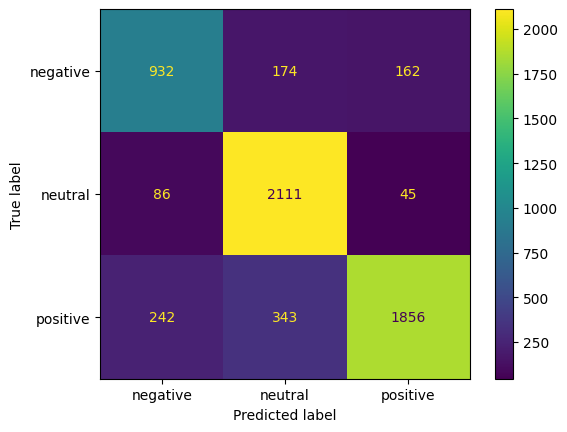

In [122]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm,X_test_processed,
                                      y_test,display_labels=le.classes_)

In [123]:
# cross validation score
from imblearn.pipeline import Pipeline as Pipe
from sklearn.model_selection import cross_val_score

cross_val_pipe = Pipe([
    ('preprocess',preprocessor),
    #('sampler',adasyn),
    ('lgbm',LGBMClassifier(random_state=42))
])

scores = cross_val_score(cross_val_pipe,X_train,y_train,cv=5,scoring='f1_macro')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.280527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7583
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 2009
[LightGBM] [Info] Start training from score -1.546098
[LightGBM] [Info] Start training from score -0.976079
[LightGBM] [Info] Start training from score -0.891265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.312382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7805
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 2065
[LightGBM] [Info] Start training from score -1.546098
[LightGBM] [Info] Start training from score -0.976079
[LightGBM] [Info] St

In [124]:
print("The mean score after upsampling and training is ",scores.mean())

The mean score after upsampling and training is  0.7955841455951329


### Light GBM + Adasyn(Upsampling)

In [125]:
# fit the model on data

lgbm = LGBMClassifier(random_state=42)

lgbm.fit(X_train_upsampled,y_train_upsampled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.883047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35510
[LightGBM] [Info] Number of data points in the train set: 28512, number of used features: 3201
[LightGBM] [Info] Start training from score -1.077890
[LightGBM] [Info] Start training from score -1.147781
[LightGBM] [Info] Start training from score -1.071930


LGBMClassifier(random_state=42)

#### Predictions

In [126]:
# get the predictions on test data
y_pred_train = lgbm.predict(X_train_upsampled)
y_pred_test = lgbm.predict(X_test_processed)

#### Evaluation

In [127]:
# print classification report on train data

print(classification_report(y_train_upsampled,y_pred_train))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      9703
           1       0.81      0.95      0.88      9048
           2       0.89      0.83      0.86      9761

    accuracy                           0.87     28512
   macro avg       0.88      0.88      0.87     28512
weighted avg       0.88      0.87      0.87     28512



In [128]:
# print the classification report on test data

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.66      0.74      1268
           1       0.80      0.95      0.87      2242
           2       0.86      0.81      0.83      2441

    accuracy                           0.83      5951
   macro avg       0.83      0.80      0.81      5951
weighted avg       0.83      0.83      0.83      5951



In [129]:
# print the accuracy score

print(f'The accuracy score is {accuracy_score(y_test,y_pred_test)}')

The accuracy score is 0.8287682742396236


In [130]:
# print the f1 score

print(f'The f1 score is {f1_score(y_test,y_pred_test,average="macro")}')

The f1 score is 0.8127651595947795


In [131]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

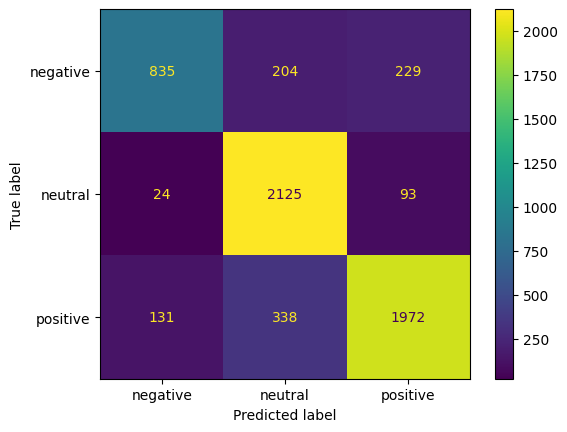

In [132]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm,X_test_processed,
                                      y_test,display_labels=le.classes_)

In [133]:
# cross validation score
from imblearn.pipeline import Pipeline as Pipe
from sklearn.model_selection import cross_val_score

cross_val_pipe = Pipe([
    ('preprocess',preprocessor),
    ('sampler',adasyn),
    ('lgbm',lgbm)
])

scores = cross_val_score(cross_val_pipe,X_train,y_train,cv=5,scoring='f1_macro')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.831512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26851
[LightGBM] [Info] Number of data points in the train set: 22663, number of used features: 2619
[LightGBM] [Info] Start training from score -1.105164
[LightGBM] [Info] Start training from score -1.126169
[LightGBM] [Info] Start training from score -1.065457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.634168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25672
[LightGBM] [Info] Number of data points in the train set: 22506, number of used features: 2631
[LightGBM] [Info] Start training from score -1.104629
[LightGBM] [Info] Start training from score -1.134161
[LightGBM] [Info] 

In [134]:
print("The mean score after upsampling and training is ",scores.mean())

The mean score after upsampling and training is  0.8023038254721276


### Light GBM + SmoteTomek

In [135]:
# fit the model on data

lgbm = LGBMClassifier(random_state=42)

lgbm.fit(X_train_combined,y_train_combined)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.179789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35917
[LightGBM] [Info] Number of data points in the train set: 29185, number of used features: 3199
[LightGBM] [Info] Start training from score -1.096798
[LightGBM] [Info] Start training from score -1.099881
[LightGBM] [Info] Start training from score -1.099161


LGBMClassifier(random_state=42)

#### Predictions

In [136]:
# get the predictions on test data
y_pred_train = lgbm.predict(X_train_combined)
y_pred_test = lgbm.predict(X_test_processed)

#### Evaluation

In [137]:
# print classification report on train data

print(classification_report(y_train_combined,y_pred_train))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      9746
           1       0.82      0.94      0.87      9716
           2       0.89      0.83      0.86      9723

    accuracy                           0.87     29185
   macro avg       0.88      0.87      0.87     29185
weighted avg       0.88      0.87      0.87     29185



In [138]:
# print the classification report on test data

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.66      0.74      1268
           1       0.80      0.95      0.87      2242
           2       0.86      0.81      0.83      2441

    accuracy                           0.83      5951
   macro avg       0.83      0.80      0.81      5951
weighted avg       0.83      0.83      0.82      5951



In [139]:
# print the accuracy score

print(f'The accuracy score is {accuracy_score(y_test,y_pred_test)}')

The accuracy score is 0.82826415728449


In [140]:
# print the f1 score

print(f'The f1 score is {f1_score(y_test,y_pred_test,average="macro")}')

The f1 score is 0.8119782635281959


In [141]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

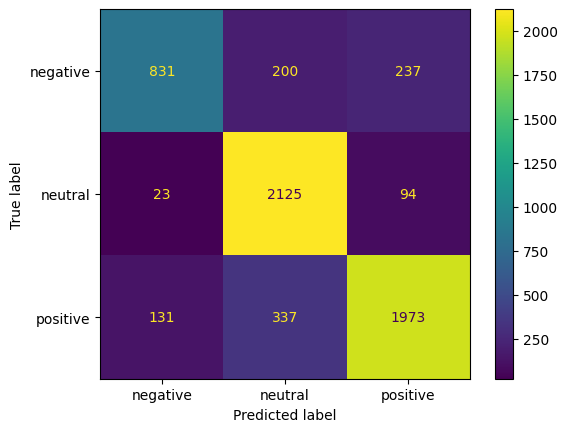

In [142]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm,X_test_processed,
                                      y_test,display_labels=le.classes_)

In [143]:
# cross validation score
from imblearn.pipeline import Pipeline as Pipe
from sklearn.model_selection import cross_val_score

cross_val_pipe = Pipe([
    ('preprocess',preprocessor),
    ('sampler',smote_tom),
    ('lgbm',LGBMClassifier(random_state=42))
])

scores = cross_val_score(cross_val_pipe,X_train,y_train,cv=5,scoring='f1_macro')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.653835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27816
[LightGBM] [Info] Number of data points in the train set: 23341, number of used features: 2644
[LightGBM] [Info] Start training from score -1.096729
[LightGBM] [Info] Start training from score -1.099813
[LightGBM] [Info] Start training from score -1.099298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.181683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28236
[LightGBM] [Info] Number of data points in the train set: 23331, number of used features: 2686
[LightGBM] [Info] Start training from score -1.096814
[LightGBM] [Info] Start training from score -1.099899
[LightGBM] [Info] 

In [144]:
print("The mean score after combined sampling and training is ",scores.mean())

The mean score after combined sampling and training is  0.8015822545298983
